In [1]:
import numpy as np
import pandas as pd 
import itertools
import matplotlib.pyplot as plt 
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

import seaborn as sns


In [2]:
sns.set_theme(style="whitegrid", palette="pastel")

In [37]:
def give_weighted_rank(aggregations_ranked_unweighted, ranked_test_acc, comparator_method='median', weighting_method='real_line'):
    
    if comparator_method == "median":
        #middle = len(ranked_test_acc) // 2
        #comparator_test_acc = np.mean([ranked_test_acc[middle - 1], ranked_test_acc[middle]])
        comparator_test_acc = np.median(ranked_test_acc)
    elif comparator_method == 'mean':
        comparator_test_acc = np.mean(ranked_test_acc)

    weighted_rank = []
    for i, rank in enumerate(aggregations_ranked_unweighted):
        diff_test_acc = (ranked_test_acc[i] - comparator_test_acc)
        
        adjusted_rank_value = rank 
        if weighting_method == "splaying":
            adjusted_rank_value = rank * (1 - diff_test_acc)

        if weighting_method =="real_line":
            adjusted_rank_value = diff_test_acc

        
        weighted_rank.append(adjusted_rank_value)
    return weighted_rank

def remove_min_max_columns(df):
    columns_to_keep = [col for col in df.columns if 'MAX' not in col and 'MIN' not in col]
    df = df[columns_to_keep]
    return df
    
def reformat_node_slicing_df(df):
    df = remove_min_max_columns(df)

    new_dataframes = []
    for col in df.columns:
        if col =="Step":
            continue
        num_clients = int(col.split("_")[2].split('-')[0])
        percentage_overlap = int(col.split("_")[4].split('-')[0])
        aggregation_strategy = col.split("_")[6].split(' ')[0]
        new_df = pd.DataFrame(df[col])
        new_df["steps"] = new_df.index
        new_df = new_df.rename(columns={col: "test_accuracy"})
        new_df["num_clients"] =num_clients
        new_df["percentage_overlap"] =percentage_overlap
        new_df["aggregation_strategy"] =aggregation_strategy
    
        new_dataframes.append(new_df)
    
    big_df = pd.concat(new_dataframes)

    return big_df

def get_client_split_dfs(new_df):
    last_step_df = new_df.loc[new_df['steps']==49]
    df_2_clients = last_step_df[last_step_df['num_clients'] == 2]
    df_4_clients = last_step_df[last_step_df['num_clients'] == 4]
    df_8_clients = last_step_df[last_step_df['num_clients'] == 8]
    df_10_clients = last_step_df[last_step_df['num_clients'] == 10]
    
    
    reformatted_dfs = []
    for df in [df_2_clients, df_4_clients, df_8_clients, df_10_clients]:
        sorted_groups = df.groupby('percentage_overlap').apply(lambda x: x.sort_values('test_accuracy', ascending=False))
        sorted_groups = sorted_groups.reset_index(drop=True)
    
        reformatted_data = {}
        
        for overlap in sorted_groups['percentage_overlap'].unique():
            reformatted_data[overlap] = sorted_groups[sorted_groups['percentage_overlap'] == overlap]['aggregation_strategy'].values
            reformatted_data[f"{overlap}_test_accuracy"] = sorted_groups[sorted_groups['percentage_overlap'] == overlap]['test_accuracy'].values
        reformatted_df = pd.DataFrame(reformatted_data)
        reformatted_dfs.append(reformatted_df)
    return reformatted_dfs
    
def read_in_csv(slice_method, dataset):
    path = f"wandb_data/overlap_experiments_method{slice_method}/{dataset}.csv"
    df = pd.read_csv(path)
    df = reformat_node_slicing_df(df)
    
    df = df.reset_index()
    # missing_df = df.loc[df['test_accuracy'].isna()]
    # if len(missing_df) !=0:
    #     missing_df["num_clients_percentage_overlap_aggregation_strategy"] = "num_clients-" + missing_df['num_clients'].astype(str)+ "_percentage_overlap-" + missing_df['percentage_overlap'].astype(str) + "_" + missing_df['aggregation_strategy']
    #     raise Exception(f"Error: missing parts of run. Please rerun : {list(missing_df['num_clients_percentage_overlap_aggregation_strategy'].unique())}")
    return df 

def get_rank_and_weighted_rank(df):
    idx = df.groupby(['num_clients', 'percentage_overlap', 'aggregation_strategy'])['test_accuracy'].idxmax()
    df = df.loc[idx]
    df['neg_test_accuracy'] = - df['test_accuracy']
    
    df['rank'] = df.groupby(['num_clients', 'percentage_overlap'])['neg_test_accuracy'].rank("max")
    df = df.drop(columns=["neg_test_accuracy"])

    var1 = "num_clients"
    var2 = "percentage_overlap"
    var1_vals = df[var1].unique()
    var2_vals = df[var2].unique()
    vars = list(itertools.product(var1_vals, var2_vals))
    
    new_dfs = []
    for var1_val, var2_val in vars: 
        new_df = df.copy()
        new_df = new_df.loc[(new_df[var1]==var1_val) & (new_df[var2]==var2_val)]
        new_df = new_df.sort_values(by='test_accuracy', ascending=False)
        test_accuracy = list(new_df['test_accuracy'])
        raw_rank = list(new_df['rank'])
        weighted_rank = give_weighted_rank(aggregations_ranked_unweighted = raw_rank, ranked_test_acc = test_accuracy)
        new_df['weighted_rank'] = weighted_rank
        new_dfs.append(new_df)
    df = pd.concat(new_dfs)
    return df

def fix_var_average_agg_performance(df, fixed_var, median_col="weighted_rank"):
    fixed_var_vals = sorted(df[fixed_var].unique())
    
    aggregation_strategies = df['aggregation_strategy'].unique()
    
    fixed_var_dict = {}
    for fixed_var_val in fixed_var_vals: 
        fixed_var_dict[f"{fixed_var_val}"] = {}
        for aggregation_strategy in aggregation_strategies:
            filtered_df = df.loc[(df['aggregation_strategy']==aggregation_strategy) & (df[fixed_var] == fixed_var_val)]
            fixed_var_dict[f"{fixed_var_val}"][aggregation_strategy] = np.mean(filtered_df[median_col])
    return fixed_var_dict

def plot_graph(plot_df, title, x_label, y_label, dataset, node_slice_method, ax, color_map, inverse_x_ticks: bool, y_range=None, fac=17, loc="lower left"):
    sns.set_theme(style="whitegrid")  

    strategies = ['FedProx', 'FedAvg', 'FedOpt', 'FedAdagrad', 'FedYogi', 'FedAdam'] 
    
    new_index = [f"{idx} | {val}" for idx, val in zip(plot_df.index, plot_df['median'])]
    plot_df.index = new_index
    plot_df = plot_df.drop(columns=["median"])

    df_transposed = plot_df.transpose()[::-1] if inverse_x_ticks else plot_df.transpose()

    for column in df_transposed.columns:
        strategy = column.split(' | ')[0]
        # print(strategy)
        sns.lineplot(data=df_transposed, x=df_transposed.index, y=column, marker='o', color=color_map.get(strategy, 'grey'), ax=ax, label=strategy)

    ax.set_title(title, fontsize=fac)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_range) if y_range is not None else ax[0].set_yticks(np.arange(-0.08, 0.08, 0.01))
    ax.legend(title="Aggregation Strategy", loc=loc, fontsize=15)

    ax.set_xticks(range(len(df_transposed.index)), df_transposed.index)
    

def plot_median(df, ax, color_map, median_y_label, y_range=None, loc="lower center"):

    df['aggregation_strategy'] = df.index
    for strategy in df.aggregation_strategy.unique():
        y = df.loc[df['aggregation_strategy'] == strategy]['median']
        sns.scatterplot(x=["" for _ in range(len(y))], y=y, color=color_map[strategy], label=f"{float(np.round(y.iloc[0],3))}", ax=ax)
    ax.set_ylabel(median_y_label)
    ax.set_ylim(y_range) if y_range is not None else ax.set_yticks(np.arange(-0.08, 0.08, 0.01))
    ax.legend(title='Accuracy', loc=loc, fontsize=15)#, loc"lower left")
    # ax.set_title("{dataset_name}", fontdict={'fontsize': 8, 'fontweight': 'medium'})
    # ax.set_xlabel(median_x_label)

In [53]:
node_slice_method = 1
dataset = "citeseer"
loc_l = "lower"
if node_slice_method == 1 and dataset == 'citeseer':
    loc_l = "upper"
    node_slice_method = 1
    dataset = "citeseer"
    df1 = pd.read_csv(f"wandb_data/overlap_experiments_method{node_slice_method}/{dataset}1.csv")
    df2 = pd.read_csv(f"wandb_data/overlap_experiments_method{node_slice_method}/{dataset}2.csv")
    df = pd.merge(df1,df2, on=df1['Step'])
    df = df.rename(columns={"Step_x": "Step"})
    df = df.drop(columns=['key_0', 'Step_y'])
    df = reformat_node_slicing_df(df)
    
    df = df.reset_index()
    missing_df = df.loc[df['test_accuracy'].isna()]
    if len(missing_df) !=0:
        missing_df["num_clients_percentage_overlap_aggregation_strategy"] = "num_clients-" + missing_df['num_clients'].astype(str)+ "_percentage_overlap-" + missing_df['percentage_overlap'].astype(str) + "_" + missing_df['aggregation_strategy']
        raise Exception(f"Error: missing parts of run. Please rerun : {list(missing_df['num_clients_percentage_overlap_aggregation_strategy'].unique())}")
else:       
    df = read_in_csv(node_slice_method, dataset)
df['aggregation_strategy'] = df['aggregation_strategy'].replace("FedProx2", "FedProx")
if len(df) != 4800:
    raise Exception("Error: redownload csv, incorrect number of rows.")
df_ = get_rank_and_weighted_rank(df.copy())
overlap_perc_fixed_n_clients_varying = fix_var_average_agg_performance(df_.copy(), "percentage_overlap", median_col="test_accuracy")
overlap_perc_fixed_n_clients_varying_df = pd.DataFrame(overlap_perc_fixed_n_clients_varying)
overlap_perc_fixed_n_clients_varying_df['median'] = overlap_perc_fixed_n_clients_varying_df.mean(axis=1).round(4)
overlap_perc_fixed_n_clients_varying_df = overlap_perc_fixed_n_clients_varying_df.sort_values('median', ascending=False)
n_clients_fixed_overlap_perc_varying = fix_var_average_agg_performance(df_.copy(), "num_clients", median_col="test_accuracy")
n_clients_fixed_overlap_perc_varying_df = pd.DataFrame(n_clients_fixed_overlap_perc_varying)
n_clients_fixed_overlap_perc_varying_df['median'] = n_clients_fixed_overlap_perc_varying_df.mean(axis=1).round(4)
n_clients_fixed_overlap_perc_varying_df = n_clients_fixed_overlap_perc_varying_df.sort_values('median', ascending=False)

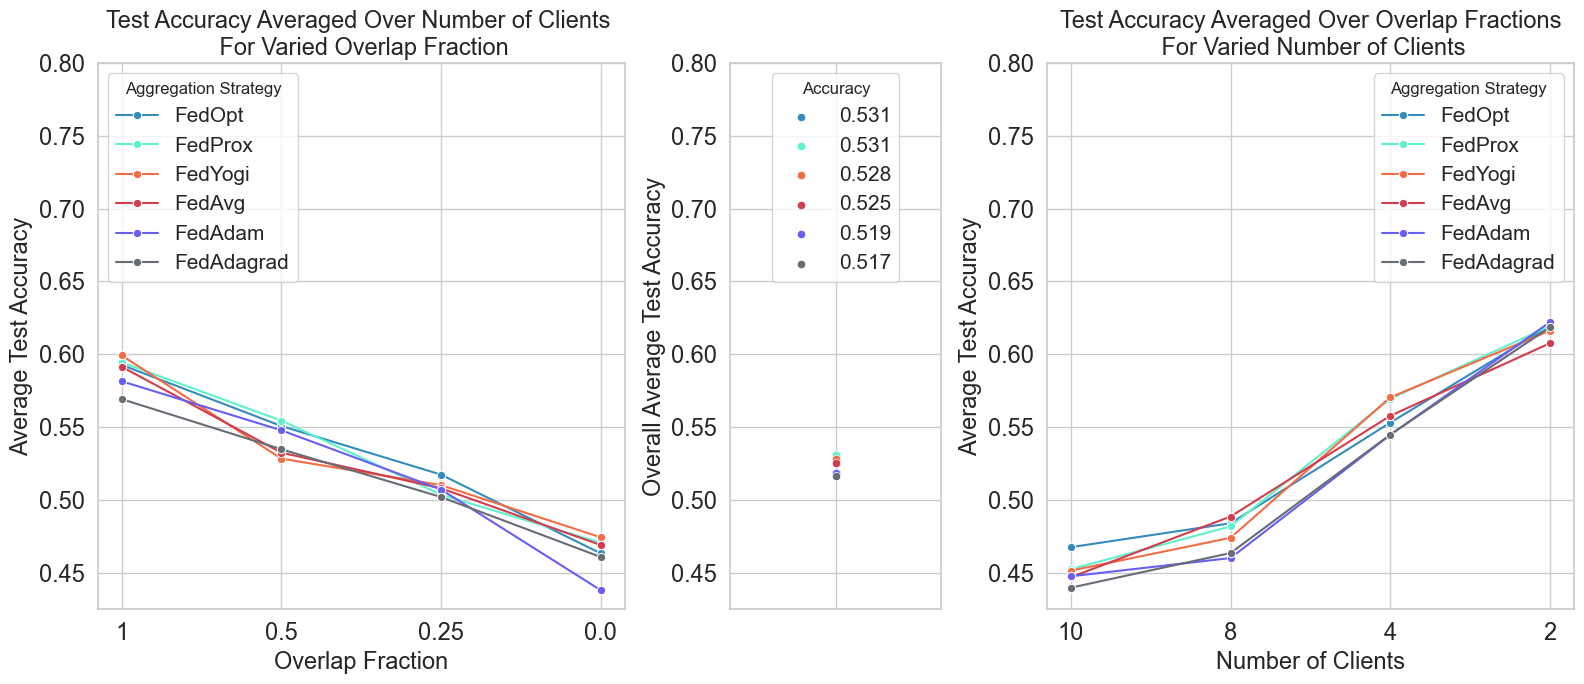

In [54]:
import matplotlib.pylab as pylab
fac = 17

params = {'legend.fontsize': f'{fac}',
          'figure.figsize': (16, 7),
         'axes.labelsize': f'{fac}',
         'axes.titlesize':f'{fac}',
         'xtick.labelsize':f'{fac}',
         'ytick.labelsize':f'{fac}',
         'legend.fontsize':f"{500}"
          # 'title.size': '15'
          # 'figure.titlesize': '15' 
         }
pylab.rcParams.update(params)
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2.5, 1, 2.5]}, figsize=(16, 7))
color_map = {
    'FedProx': (94/255, 242/255, 205/255),
    'FedAvg': (211/255,60/255,76/255),
    'FedOpt': (52/255,140/255,188/255),
    'FedAdagrad': (103/255,109/255,117/255),
    'FedYogi': (243/255,108/255,68/255),
    'FedAdam': (104/255, 94/255, 242/255)
}

y_range = (0.425, 0.8)
overlap_perc_fixed_n_clients_varying_df.columns = ["0.0", "0.25", "0.5", "1", "median"]
plot_graph(overlap_perc_fixed_n_clients_varying_df.copy(), 
        title="Test Accuracy Averaged Over Number of Clients \n For Varied Overlap Fraction",
           x_label="Overlap Fraction", 
           y_label="Average Test Accuracy", 
           dataset=dataset, 
           node_slice_method = node_slice_method,
           ax = ax[0], 
           color_map = color_map, 
           inverse_x_ticks = True, 
           y_range=y_range,
           fac=fac,
           loc=f"{loc_l} left"
           
          )

median_y_label = "Overall Average Test Accuracy"
plot_median(overlap_perc_fixed_n_clients_varying_df.copy(), 
            ax=ax[1], color_map=color_map, median_y_label=median_y_label, y_range=y_range,
           loc=f"{loc_l} center"
           
           )

plot_graph(n_clients_fixed_overlap_perc_varying_df.copy(), 
        title="Test Accuracy Averaged Over Overlap Fractions\n For Varied Number of Clients",
           x_label="Number of Clients", 
           y_label="Average Test Accuracy", 
           dataset=dataset, 
           node_slice_method = node_slice_method,
           ax = ax[2], 
           color_map = color_map, 
           inverse_x_ticks = True, 
           y_range=y_range, 
           fac=fac,
           loc=f"{loc_l} right"
          )

plt.tight_layout()

output_dir = f"outputs/figs"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(f"{output_dir}/{dataset}_slice_{node_slice_method}.pdf")
plt.savefig(f"{output_dir}/{dataset}_slice_{node_slice_method}.png")

plt.show()
